### Set up libraries%load_ext autoreload

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
from typing import Dict, Tuple
import warnings

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import thundersvm

import jax
import jax.numpy as jnp
from jax.interpreters import xla
jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_platform_name", "cpu")

import neural_tangents as nt
from neural_tangents import stax

jnp.array([0]) # So warnings don't show up later
jax.local_devices()

[GpuDevice(id=0, task=0)]

In [4]:
import sys
sys.path.append("../../../..")

from adversarial_ntks import dataset, attacks, min_attack, jthunder, kernel

### Load Data

In [5]:
%%time

MNIST_TRAIN = dataset.get_np_data(
    name="mnist", split="train", agg_labels=((0,1,2,3,4), (5,6,7,8,9)))
MNIST_TEST = dataset.get_np_data(
    name="mnist", split="test", agg_labels=((0,1,2,3,4), (5,6,7,8,9)))

CIFAR_TRAIN = dataset.get_np_data(
    name="cifar10", split="train", agg_labels=((0,1,2,3,4), (5,6,7,8,9)))
CIFAR_TEST = dataset.get_np_data(
    name="cifar10", split="test", agg_labels=((0,1,2,3,4), (5,6,7,8,9)))

print(MNIST_TRAIN.xs.shape)
print(MNIST_TEST.xs.shape)
print(CIFAR_TRAIN.xs.shape)
print(CIFAR_TEST.xs.shape)

(60000, 784)
(10000, 784)
(50000, 3072)
(10000, 3072)
CPU times: user 25.2 s, sys: 27.5 s, total: 52.7 s
Wall time: 10.5 s


[0 0 0 1 1 0 0 1 0 1]


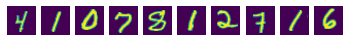

[0 0 0 1 1 1 0 1 0 0]


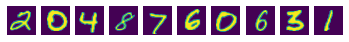

[1 1 0 0 1 1 0 1 1 1]


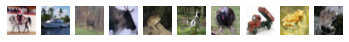

[1 0 1 1 1 0 1 0 0 0]


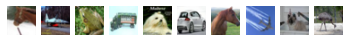

In [6]:
dataset.plot_images(MNIST_TRAIN, channels=1)
dataset.plot_images(MNIST_TEST, channels=1)
dataset.plot_images(CIFAR_TRAIN, channels=3)
dataset.plot_images(CIFAR_TEST, channels=3)

### Utility code

In [7]:
def avg_by_cls(xs, ys) -> Tuple[float, float]:
    return (xs[ys == 0].mean(), xs[ys == 1].mean())

def accs_by_cls(clf: thundersvm.SVC, ds: dataset.Dataset) -> Tuple[float, float]:
    return avg_by_cls(clf.predict(ds.xs) == ds.ys, ds.ys)

def fmt_accs(accs: Tuple) -> str:
    return "(" + ", ".join(f"{a:.4f}" for a in accs) + ")"

def print_dict(d: Dict):
    def fmt(v):
            if isinstance(v, tuple):
                return fmt_accs(v)
            elif isinstance(v, float):
                return f"{v:.2e}"
            return v
            
    print({
        k : fmt(v) for
        k, v in d.items()
        if not isinstance(v, np.ndarray)
    })
    
def print_clf_info(clf: thundersvm.SVC):
    print_dict(dict(
        n_support=list(clf.n_support_),
        b=clf.intercept_[0],
        gam=clf._gamma,
        coef0=clf.coef0,
    ))

In [8]:
def eval_ds(
    clf: thundersvm.SVC,
    ds: dataset.Dataset,
    attack_norm: int,
    attack_eps: float,
    pgd_step_size: float,
    pgd_num_steps: int,
    batch_size: int
) -> Dict:
    res_dict = dict()
    
    res_dict["accs_nat"] = accs_by_cls(clf=clf, ds=ds)
    res_dict["acc_nat"] = sum(res_dict["accs_nat"]) / 2
    print(f"accs_nat: {fmt_accs(res_dict['accs_nat'])}")
    print(f"acc_nat: {res_dict['acc_nat']:.4f}")
    
    clf_grad_fn = jthunder.get_grad_decision_function(clf)
    
    xs_pgd = attacks.pgd(
        X=ds.xs, Y=ds.ys,
        grad_func=clf_grad_fn,
        eps=attack_eps, eps_norm=attack_norm,
        step_size=pgd_step_size, step_norm=attack_norm,
        num_steps=pgd_num_steps,
        pixel_clip=True,
        batch_size=batch_size,
    )
    res_dict["xs_pgd"] = xs_pgd
    
    res_dict["preds_pgd"] = clf.predict(xs_pgd)
    res_dict["accs_pgd"] = accs_by_cls(clf=clf, ds=ds.replace_xs(xs_pgd))
    res_dict["acc_pgd"] = sum(res_dict["accs_pgd"]) / 2
    print(f"accs_pgd: {fmt_accs(res_dict['accs_pgd'])}")
    print(f"acc_pgd: {res_dict['acc_pgd']:.4f}")
    
    return res_dict

In [9]:
def compute_margins(
    clf: thundersvm.SVC,
    ds: dataset.Dataset,
    attack_norm: int,
    attack_eps: float,
    pgd_step_size: float,
    pgd_num_steps: int,
    batch_size: int
) -> Dict:
    res_dict = dict()
    
    clf_grad_fn = jthunder.get_grad_decision_function(clf)
    clf_pred_fn_base = jthunder.get_decision_function(clf)
    clf_pred_fn_neg = lambda xs: - clf_pred_fn_base(xs)
    
    clf_pred_fn = clf_pred_fn_base
    
    res_dict["ys"] = ds.ys
    res_dict["preds"] = clf.predict(ds.xs)
    
    res_dict["activations"] = min_attack.batch_predict(
        X = ds.xs,
        pred_fn=clf_pred_fn,
        batch_size=batch_size
    )
    #-clf.decision_function(ds.xs).flatten()
    #assert np.all((res_dict["preds"] == 1) == (res_dict["activations"] > 0))
    
    res_dict["fmarg"] = (2 * ds.ys - 1) * res_dict["activations"]
    
    res_dict["norm"] = np.sqrt(jthunder.norm2(clf))
    res_dict["gmarg"] = res_dict["fmarg"] / res_dict["norm"]
    
    xs_min_adv, xs_pgd = min_attack.compute_min_perturbation(
        X=ds.xs,
        grad_fn=clf_grad_fn,
        pred_fn=clf_pred_fn,
        eps=attack_eps, eps_norm=attack_norm,
        step_size=pgd_step_size, step_norm=attack_norm,
        num_steps=pgd_num_steps,
        batch_size=batch_size,
    )
    
    res_dict["xs_min_adv"] = xs_min_adv
    res_dict["xs_pgd"] = xs_pgd
    
    res_dict["dmarg"] = (
        np.sign(res_dict["fmarg"])
        * np.linalg.norm(ds.xs - xs_min_adv, ord=2, axis=-1)
    )
    
    return res_dict

### Margin bounds

In [10]:
def psi_rbf(diff, bandwidth):
    return np.exp(-(diff / bandwidth) ** 2)

def delta_rbf(dmarg, bandwidth):
    return np.sqrt(2 * (1 - psi_rbf(diff=dmarg, bandwidth=bandwidth)))

def delta_inv_rbf(gmarg, bandwidth):
    return bandwidth * np.sqrt(-np.log(1 - 0.5 * gmarg ** 2))

Text(0.5, 1.0, 'Lower bound of data-margin by geometric-margin')

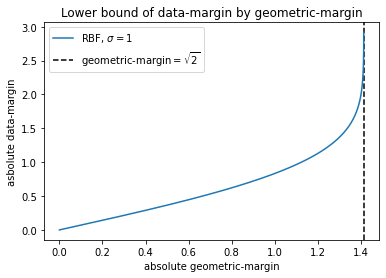

In [11]:
BW=1

gmargs = np.linspace(0, np.sqrt(2), num=10000, endpoint=False)
delta_inv_gmargs = delta_inv_rbf(gmargs, bandwidth=BW)
plt.plot(gmargs, delta_inv_gmargs, label=f"RBF, $\sigma={BW}$")

# Check inverse
# dmargs = np.linspace(0, 10, num=1000)
# delta_dmargs = delta_rbf(dmargs, bandwidth=10)
# plt.plot(delta_dmargs, dmargs, linestyle="-.", color="red")

plt.axvline(np.sqrt(2), color="black", linestyle="--", zorder=-10,
            label="geometric-margin$= \sqrt{2}$")

plt.xlabel("absolute geometric-margin")
plt.ylabel("asbolute data-margin")
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1);
plt.title("Lower bound of data-margin by geometric-margin")

### Train models

In [12]:
%%time
clf_mnist = thundersvm.SVC(kernel="rbf", C=1000)
clf_mnist.fit(MNIST_TRAIN.xs[:2048], MNIST_TRAIN.ys[:2048]);

CPU times: user 702 ms, sys: 0 ns, total: 702 ms
Wall time: 792 ms


SVC(C=1000, class_weight={})

In [13]:
tmp_dict = eval_ds(
    clf=clf_mnist,
    ds=MNIST_TEST.prefix(1024),
    attack_norm=2,
    attack_eps=2,
    pgd_step_size=2.0/10,
    pgd_num_steps=20,
    batch_size=256,
);

accs_nat: (0.9539, 0.9245)
acc_nat: 0.9392


  0%|          | 0/4 [00:00<?, ?it/s]

accs_pgd: (0.0000, 0.0000)
acc_pgd: 0.0000


In [14]:
mnist_dict = compute_margins(
    clf=clf_mnist,
    ds=MNIST_TEST.prefix(256),
    attack_norm=2,
    attack_eps=2.0,
    pgd_step_size=2.0/20,
    pgd_num_steps=40,
    batch_size=256,
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

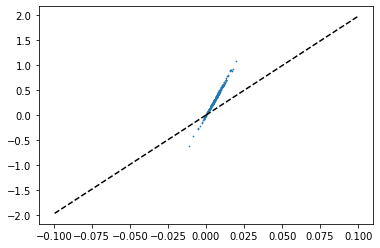

In [15]:
plt.scatter(mnist_dict["gmarg"], mnist_dict["dmarg"], s=0.5)

gmargs = np.linspace(0, 0.1, num=10000, endpoint=False)
delta_inv_gmargs = delta_inv_rbf(gmargs, bandwidth=np.sqrt(1/clf_mnist._gamma))
plt.plot(gmargs, delta_inv_gmargs, color="black", linestyle="--")
plt.plot(-gmargs, -delta_inv_gmargs, color="black",linestyle="--")